## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [2]:
conn = psycopg2.connect(
    host = 'localhost',
    database = 'healthcare',
    user = 'postgres',
    password = '2526',
    port = '5432'
)

In [3]:
cur = conn.cursor()

cur.execute('''
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'public';
''')

tables = cur.fetchall()

for table in tables:
    print(table[0])

data
billing
doctors
patients
visits
word_meanings


In [4]:
data = pd.read_sql("SELECT * FROM data;", conn)
data.head()

,patient_id,patient_name,age,gender,city,doctor_id,dr_name,dr_specialization,dr_experience_years,visit_id,visit_date,diagnosis,bill_id,amount,payment_method
0,1,Jason Wood,23,Male,Sergiofurt,1486,Ronald Bridges Jr.,Cardiologist,1,1444,2024-07-25,Hypertension,1444,417.71,Cash
1,2,Gabrielle Park,22,Male,Mercadofort,1044,Katie George,General Physician,40,1413,2024-10-25,Cancer Screening,1413,1575.27,Online
2,3,Tyler Robinson,88,Male,North Latasha,1158,Kyle Sullivan,Cardiologist,30,1459,2024-07-04,Flu,1459,4809.90,Insurance
3,4,John Randall,34,Male,Robertberg,1196,Heather Arroyo,Cardiologist,11,255,2024-07-30,Cancer Screening,255,2201.64,Cash
4,5,Sylvia Dominguez,37,Female,Port Nancy,1197,Nicole Pitts,Neurologist,25,358,2025-06-16,Flu,358,3285.96,Cash


## Data Cleaning

In [5]:
# Remove unwanted columns.
data.drop(columns=['patient_id', 'doctor_id', 'visit_id', 'bill_id'], inplace=True)
data.head(3)

,patient_name,age,gender,city,dr_name,dr_specialization,dr_experience_years,visit_date,diagnosis,amount,payment_method
0,Jason Wood,23,Male,Sergiofurt,Ronald Bridges Jr.,Cardiologist,1,2024-07-25,Hypertension,417.71,Cash
1,Gabrielle Park,22,Male,Mercadofort,Katie George,General Physician,40,2024-10-25,Cancer Screening,1575.27,Online
2,Tyler Robinson,88,Male,North Latasha,Kyle Sullivan,Cardiologist,30,2024-07-04,Flu,4809.90,Insurance


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_name         1500 non-null   object 
 1   age                  1500 non-null   int64  
 2   gender               1500 non-null   object 
 3   city                 1500 non-null   object 
 4   dr_name              1500 non-null   object 
 5   dr_specialization    1500 non-null   object 
 6   dr_experience_years  1500 non-null   int64  
 7   visit_date           1500 non-null   object 
 8   diagnosis            1500 non-null   object 
 9   amount               1500 non-null   float64
 10  payment_method       1500 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 129.0+ KB


In [7]:
# Convert visit_date column to datetime
data["visit_date"] = pd.to_datetime(data["visit_date"])

## Exploratory Data Analysis

In [8]:
data.describe()

,age,dr_experience_years,visit_date,amount
count,1500.00000,1500.000000,1500,1500.000000
mean,52.27400,20.447333,2024-08-28 16:39:21.600000256,2573.515900
min,18.00000,1.000000,2023-09-04 00:00:00,100.530000
25%,34.00000,11.000000,2024-02-19 00:00:00,1410.087500
50%,52.00000,20.000000,2024-09-01 00:00:00,2583.845000
75%,70.00000,30.000000,2025-03-04 06:00:00,3753.397500
max,90.00000,40.000000,2025-09-02 00:00:00,4998.330000
std,20.75693,11.567040,NaN,1394.996153


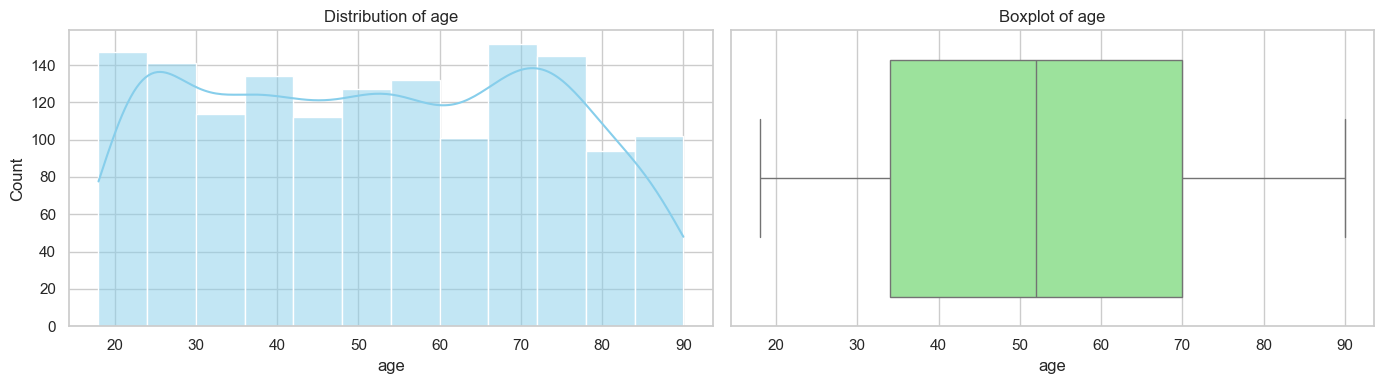

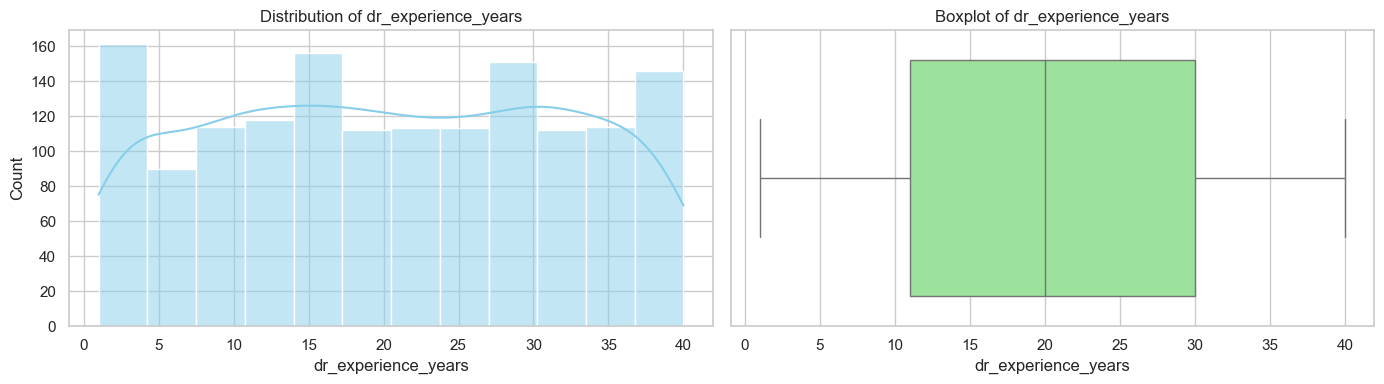

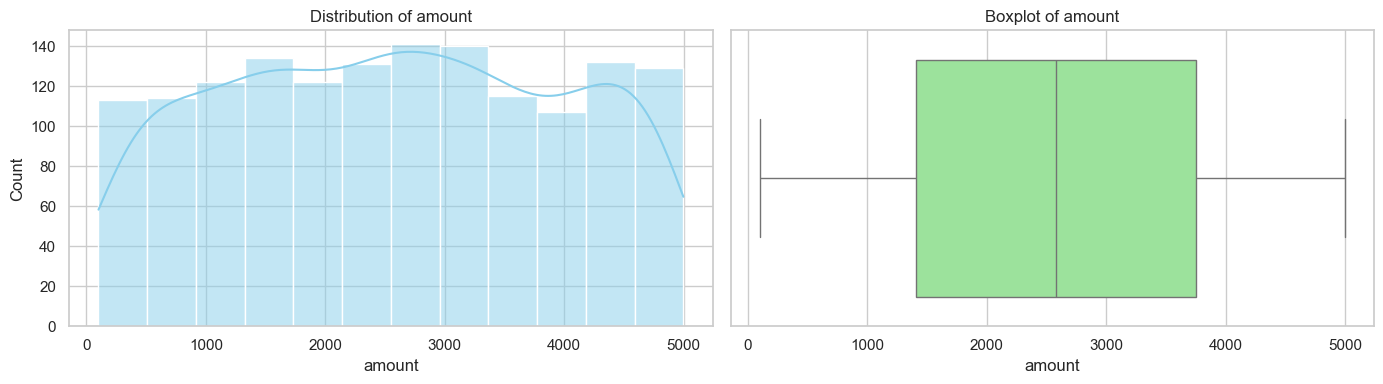

In [9]:
# Set overall style
sns.set(style="whitegrid")

numeric_cols = data.select_dtypes(include=['int64','float64']).columns

# Plot histogram and boxplot for each numerical column
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Histogram
    sns.histplot(data[col], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel(col)

    # Boxplot
    sns.boxplot(x=data[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

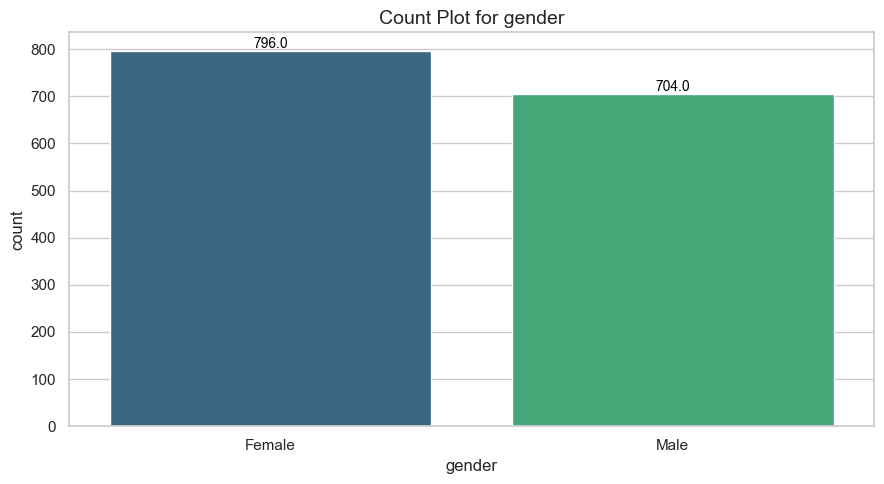

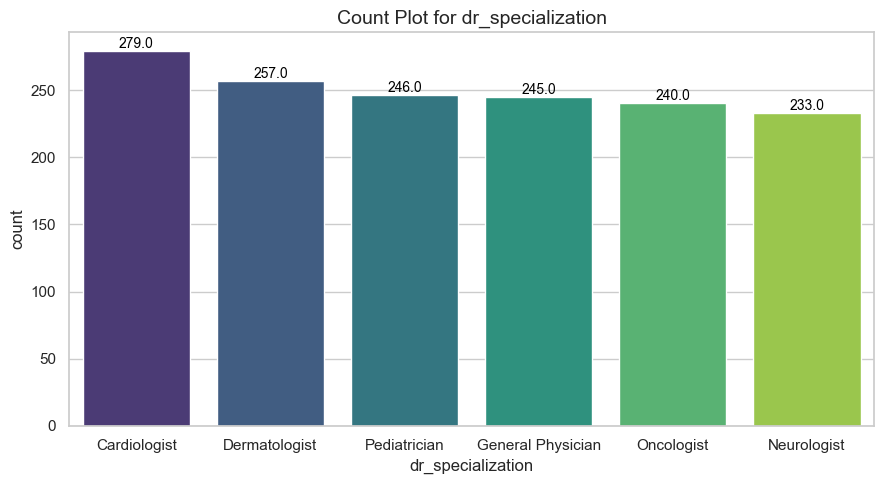

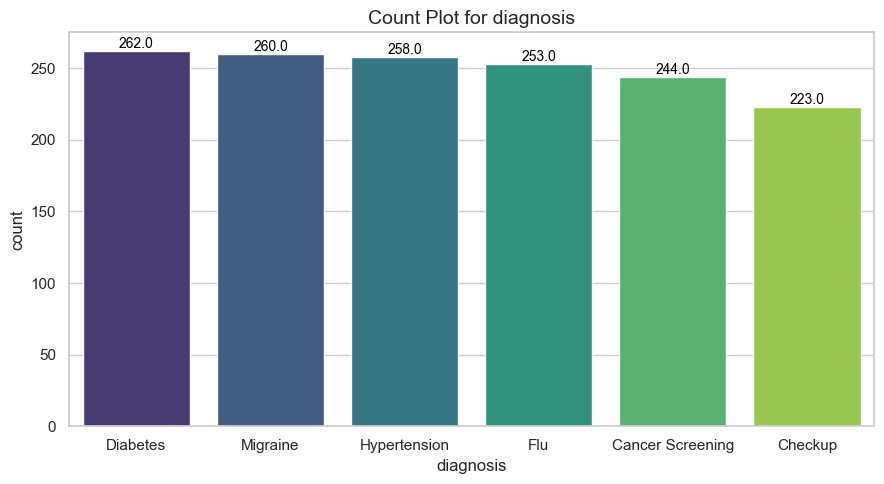

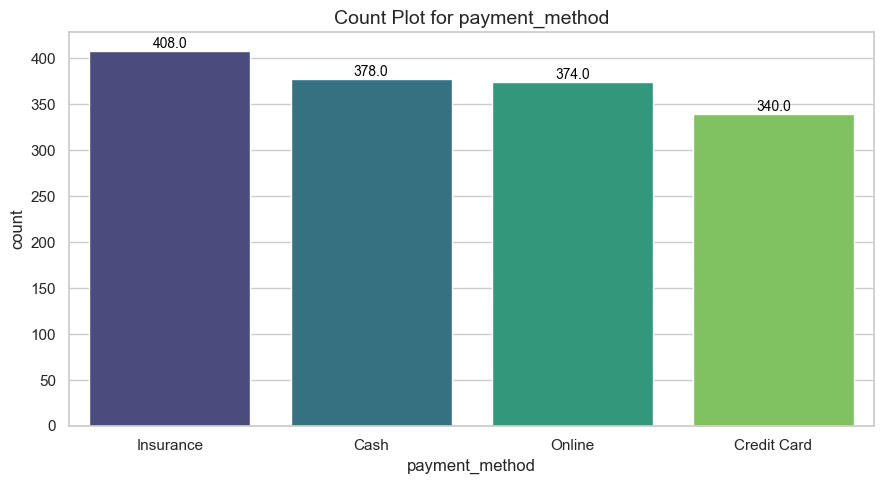

In [10]:
# Count plots for Categorical Columns

# Set seaborn style
sns.set(style="whitegrid")

# Define figure size globally
plt.rcParams["figure.figsize"] = (8, 5)

cats_cols = ["gender", "dr_specialization", "diagnosis", "payment_method"]

# Loop through categorical columns
for col in cats_cols:
    plt.figure(figsize=(9, 5))  # Bigger figure for visibility
    ax = sns.countplot(
        data=data,
        x=col,
        order=data[col].value_counts().index,
        palette="viridis"  # Better color palette
    )
    
    # Add value labels on bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')
    
    plt.title(f"Count Plot for {col}", fontsize=14)
    #plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Data Analysis

### 1. How many patients have come from each city?

In [11]:
city_counts = data.groupby("city")["patient_name"].count().reset_index()

# Rename columns for clarity
city_counts.columns = ["city", "total_patients"]

# Sort descending order
city_counts = city_counts.sort_values(by="total_patients", ascending=False)

city_counts.head(10)

,city,total_patients
884,West Lisa,6
651,Port Kenneth,6
672,Port Tiffany,6
732,South Ashley,6
530,Norrisberg,5
233,Gravesport,5
447,Michaelton,5
808,Stephenview,5
82,Christineberg,5
900,West Thomas,4


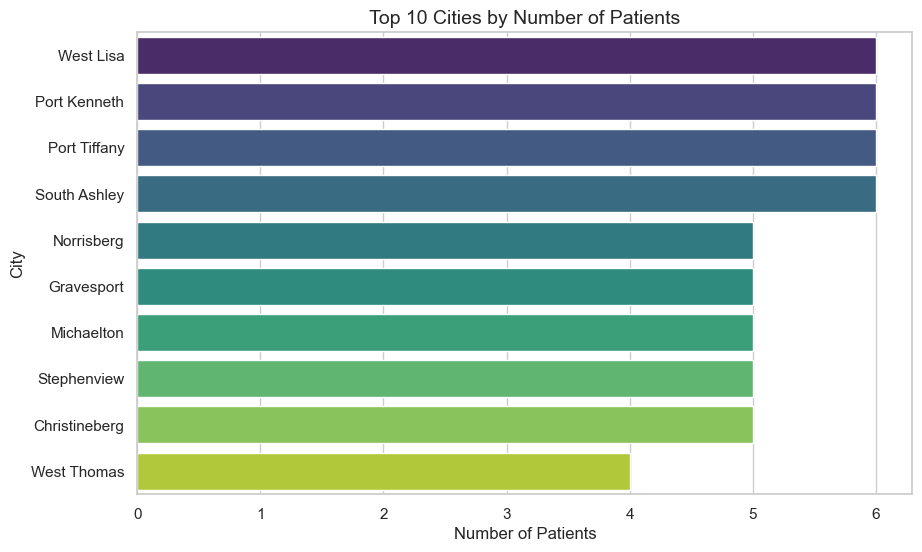

In [12]:
# Plot top 10 cities
plt.figure(figsize=(10,6))
sns.barplot(
    data=city_counts.head(10), 
    x="total_patients", 
    y="city", 
    palette="viridis"
)

plt.title("Top 10 Cities by Number of Patients", fontsize=14)
plt.xlabel("Number of Patients")
plt.ylabel("City")
plt.show()

### 2. How many patients did each doctor treat?

In [13]:
dr_counts = data.groupby("dr_name")["patient_name"].count().reset_index()

# Rename columns for clarity
dr_counts.columns = ["dr_name", "total_patients"]

# Sort descending order
dr_counts = dr_counts.sort_values(by="total_patients", ascending=False)

dr_counts.head(10)

,dr_name,total_patients
608,Mark Spencer,6
831,Shari Randolph,5
663,Michael Perez,5
460,Julia Wood,4
344,James Johnson,4
881,Theodore Parker,4
453,Joseph Parks,4
343,James Jackson,4
518,Kim Tapia,4
327,Hunter Barnett,4


### 3. What is the distribution (%) of male and female patients?

In [14]:
# Gender distribution
gender_dist = data['gender'].value_counts(normalize=True) * 100
print("Gender Distribution (%):\n", gender_dist)

Gender Distribution (%):
 gender
Female    53.066667
Male      46.933333
Name: proportion, dtype: float64


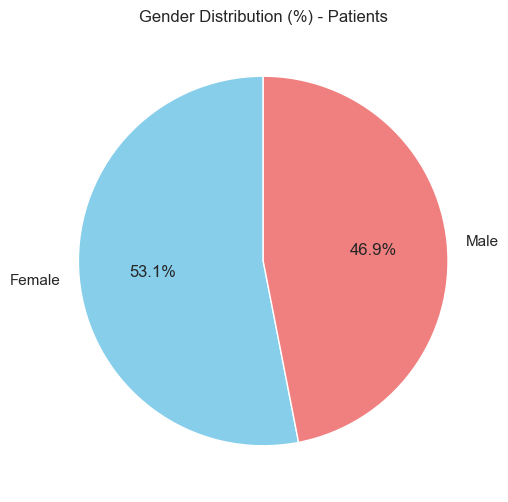

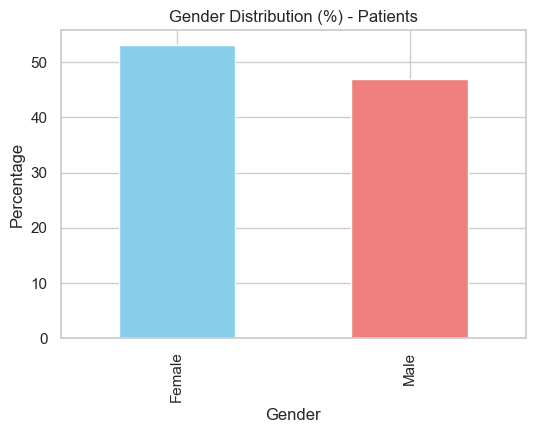

In [15]:
# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(gender_dist, labels=gender_dist.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title("Gender Distribution (%) - Patients")
plt.show()

# Bar Chart
plt.figure(figsize=(6,4))
gender_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title("Gender Distribution (%) - Patients")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.show()

### 4. Which age group (e.g., <30, 30–50, >50) has the most patients?

In [16]:
# Define age groups
bins = [0, 30, 50, 100]  # boundaries
labels = ['<30', '30-50', '>50']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# Count patients per group
age_group_dist = data['age_group'].value_counts().sort_index()
print("Patient count by age group:\n", age_group_dist)

# Find the age group with max patients
most_patients_group = age_group_dist.idxmax()
print(f"\nAge group with most patients: {most_patients_group}")

Patient count by age group:
 age_group
<30      307
30-50    401
>50      792
Name: count, dtype: int64

Age group with most patients: >50


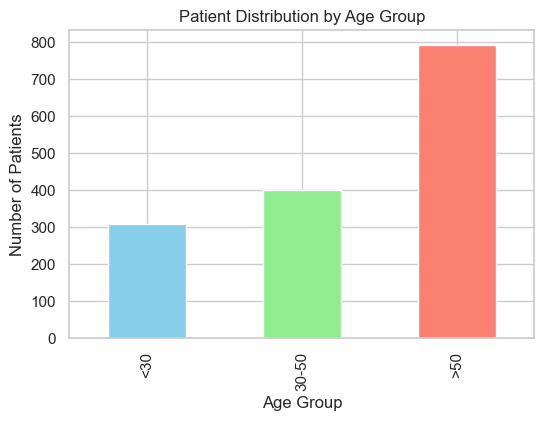

In [17]:
plt.figure(figsize=(6,4))
age_group_dist.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Patient Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.show()

### 5. Which doctor specializations are getting the most visits from patients?

In [18]:
# Count visits by specialization
specialization_dist = data['dr_specialization'].value_counts()
print("Doctor Specialization Visit Counts:\n", specialization_dist)

Doctor Specialization Visit Counts:
 dr_specialization
Cardiologist         279
Dermatologist        257
Pediatrician         246
General Physician    245
Oncologist           240
Neurologist          233
Name: count, dtype: int64


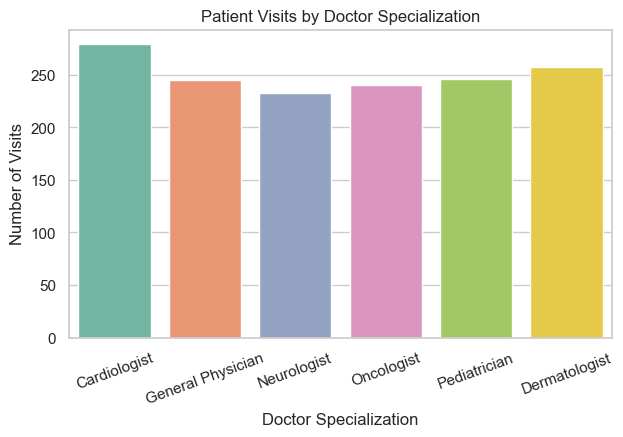

In [19]:
# Visualization using seaborn
plt.figure(figsize=(7,4))
sns.countplot(x='dr_specialization', data=data, palette='Set2')
plt.title("Patient Visits by Doctor Specialization")
plt.xlabel("Doctor Specialization")
plt.ylabel("Number of Visits")
plt.xticks(rotation=20)
plt.show()

### 6. What effect does the doctor's experience years have on the average consultation amount?

In [20]:
# Group by doctor experience years and calculate avg amount
exp_amount = data.groupby('dr_experience_years')['amount'].mean().reset_index()
print("Average Consultation Amount by Doctor's Experience:\n", exp_amount)

Average Consultation Amount by Doctor's Experience:
     dr_experience_years       amount
0                     1  2396.521702
1                     2  2658.602250
2                     3  2723.802222
3                     4  2577.542759
4                     5  2363.128718
5                     6  2379.528800
6                     7  2654.743846
7                     8  2527.843636
8                     9  2645.411316
9                    10  2541.833125
10                   11  2610.846818
11                   12  2592.579487
12                   13  2802.176000
13                   14  2486.277179
14                   15  2799.071707
15                   16  2739.330238
16                   17  2272.016176
17                   18  2640.360500
18                   19  2665.138333
19                   20  2321.249667
20                   21  2631.933778
21                   22  2920.065152
22                   23  2785.393429
23                   24  2787.643056
24                   2

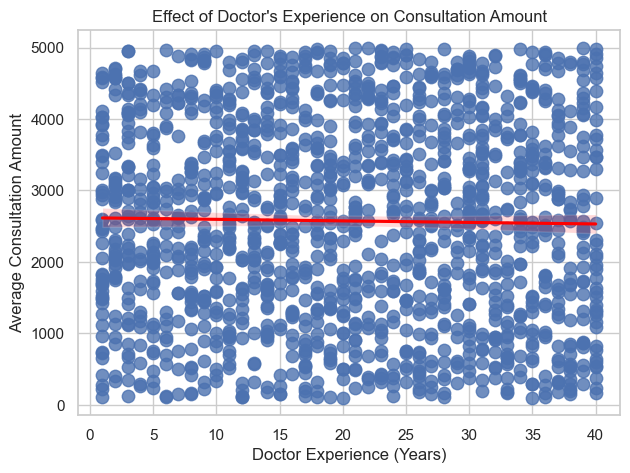

In [21]:
# Scatter plot with regression line
plt.figure(figsize=(7,5))
sns.regplot(x='dr_experience_years', y='amount', data=data, scatter_kws={'s':80}, line_kws={"color":"red"})
plt.title("Effect of Doctor's Experience on Consultation Amount")
plt.xlabel("Doctor Experience (Years)")
plt.ylabel("Average Consultation Amount")
plt.show()

### 7. Which diagnosis (hypertension, flu, cancer screening, etc.) is most common?

In [22]:
# Count diagnoses
diagnosis_count = data['diagnosis'].value_counts()
print("Diagnosis Frequency:\n", diagnosis_count)

Diagnosis Frequency:
 diagnosis
Diabetes            262
Migraine            260
Hypertension        258
Flu                 253
Cancer Screening    244
Checkup             223
Name: count, dtype: int64


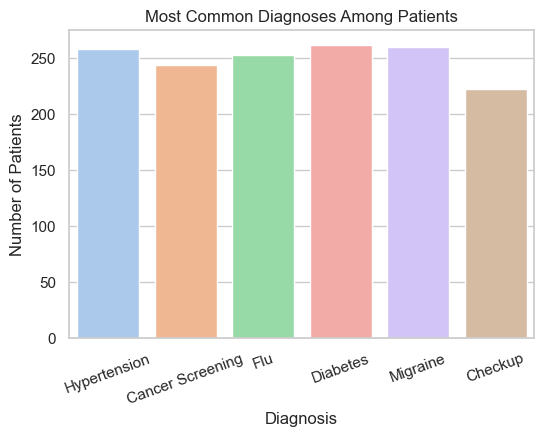

In [23]:
# Visualization
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=data, palette='pastel')
plt.title("Most Common Diagnoses Among Patients")
plt.xlabel("Diagnosis")
plt.ylabel("Number of Patients")
plt.xticks(rotation=20)
plt.show()

### 8. Which month had the most patient visits?

In [24]:
# Extract month name
data['month'] = data['visit_date'].dt.month_name()

# Count visits per month
month_visits = data['month'].value_counts()
print("Patient Visits by Month:\n", month_visits)

Patient Visits by Month:
 month
September    142
December     142
October      140
August       125
January      124
July         121
March        119
May          119
June         118
February     118
November     116
April        116
Name: count, dtype: int64


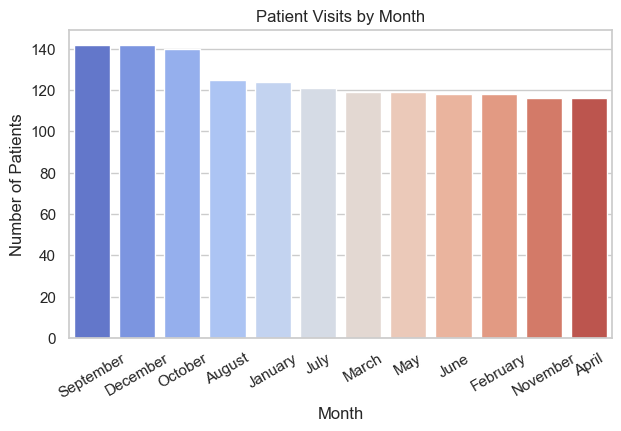

In [25]:
# Visualization
plt.figure(figsize=(7,4))
sns.countplot(x='month', data=data, order=data['month'].value_counts().index, palette='coolwarm')
plt.title("Patient Visits by Month")
plt.xlabel("Month")
plt.ylabel("Number of Patients")
plt.xticks(rotation=30)
plt.show()

### 9. Which payment method (cash, online, insurance) does he use the most?

In [26]:
# Count payment methods
payment_counts = data['payment_method'].value_counts()
print("Payment Method Usage:\n", payment_counts)

Payment Method Usage:
 payment_method
Insurance      408
Cash           378
Online         374
Credit Card    340
Name: count, dtype: int64


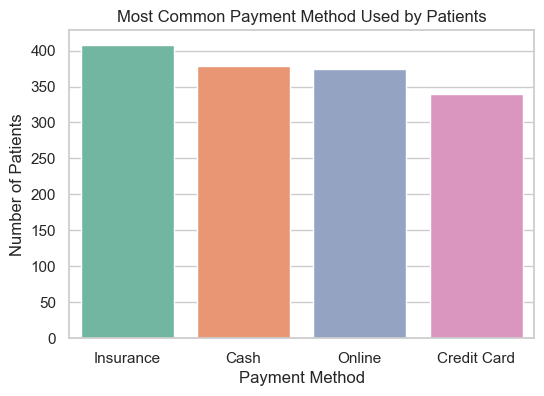

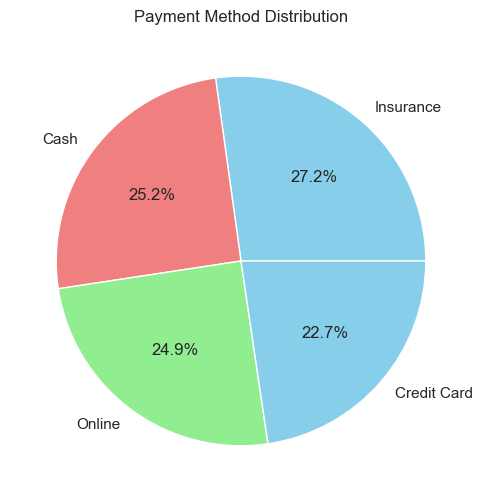

In [27]:
# Visualization - Bar Chart
plt.figure(figsize=(6,4))
sns.countplot(x='payment_method', data=data, palette='Set2', order=payment_counts.index)
plt.title("Most Common Payment Method Used by Patients")
plt.xlabel("Payment Method")
plt.ylabel("Number of Patients")
plt.show()

# Visualization - Pie Chart
plt.figure(figsize=(6,6))
payment_counts.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("Payment Method Distribution")
plt.ylabel("")
plt.show()

### 10. Average amount spent per patient kitna hai?

In [28]:
# Average amount spent per patient
avg_amount = data['amount'].mean()
display(f"Average amount spent per patient: {avg_amount:.2f}")

'Average amount spent per patient: 2573.52'

### 11. Is the treatment cost for elderly patients (60+ years) higher than that for younger patients? 

In [29]:
data['age_group'] = data['age'].apply(lambda x: 'elderly' if x >= 60 else 'younger')
avg_cost_by_age_group = data.groupby('age_group')['amount'].mean()
print(avg_cost_by_age_group)

age_group
elderly    2582.562496
younger    2567.601202
Name: amount, dtype: float64
